# Community College Analysis Project

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
# use the inline backend to generate the plots within the browser
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use('ggplot') # optional: for ggplot-like style

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import requests

!pip install mapbox
from mapbox import Geocoder


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         395 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

### Load Private Credentials

In [3]:
with open('credentials.json') as f:
    data = json.load(f)
    MAPBOX_ID = data['MAPBOX_ID']
    CLIENT_ID = data['CLIENT_ID']
    CLIENT_SECRET = data['CLIENT_SECRET']

### Read the Community Colleges Into a Data Frame

Collect all the community colleges from Phoenix, San Antonio, and Dallas Fort Worth for the latest survey data from 2018. This data comes from the Department of Education.

In [5]:
df = pd.read_csv('hd2018.csv', encoding='ISO-8859-1')

# Get all the community colleges in Phoenix Arizona
df_phx = df.loc[(df['STABBR']=='AZ')  & (df['ICLEVEL']==2) & (df['CITY'] == 'Phoenix')]
df_phx = df_phx[['UNITID', 'INSTNM', 'LONGITUD', 'LATITUDE']].reset_index(drop=True)

# Get all the community colleges in San Antonio Texas
df_san = df.loc[(df['STABBR']=='TX')  & (df['ICLEVEL']==2) & (df['CITY'] == 'San Antonio')]
df_san = df_san[['UNITID', 'INSTNM', 'LONGITUD', 'LATITUDE']].reset_index(drop=True)

# Get all the community colleges in Dallas Fort Worth Texas
df_dfw = df.loc[(df['STABBR']=='TX')  & (df['ICLEVEL']==2) & 
                ( (df['CITY'] == 'Fort Worth') | (df['CITY'] == 'Dallas') )]
df_dfw = df_dfw[['UNITID', 'INSTNM', 'LONGITUD', 'LATITUDE']].reset_index(drop=True)

# Make the columns more readable
df_phx.rename(columns={'INSTNM': 'Name', "LONGITUD": 'Longitude', 'LATITUDE': 'Latitude'}, inplace=True)
df_dfw.rename(columns={'INSTNM': 'Name', "LONGITUD": 'Longitude', 'LATITUDE': 'Latitude'}, inplace=True)
df_san.rename(columns={'INSTNM': 'Name', "LONGITUD": 'Longitude', 'LATITUDE': 'Latitude'}, inplace=True)

# Add a column for storing the neighborhood
df_phx['Neighborhood'] = None
df_dfw['Neighborhood'] = None
df_san['Neighborhood'] = None

print("Community college data loaded")

Community college data loaded


### Define Functions for Getting Neighborhood Information

These functions will connect to Google and the MapBox APIs

In [6]:
# Function to get location data from the MapBox API
def _get_mapbox_location(lat, lon):
    neighborhood = None
    city = np.nan
    
    geocoder = Geocoder(access_token=MAPBOX_ID)
    response = geocoder.reverse(lon=lon, lat=lat)
    features = sorted(response.geojson()['features'], key=lambda x: x['text'])
    
    for f in features:
        if f['id'].startswith('neighborhood'):
            neighborhood = f['text']
        elif f['id'].startswith('place'):
            city = f['text']
    
    return {'neighborhood': neighborhood , 'city': city}

# Function to get location data from the Geo API
def _get_geopy_location(lat, lon):
    neighborhood = None
    city = np.nan
    
    geolocator = Nominatim(user_agent="college_explorer")
    location = geolocator.reverse((lat, lon))
    
    features = location.raw['address']
        
    if 'neighbourhood' in features.keys():
        neighborhood = location.raw['address']['neighbourhood']
        
    if 'suburb' in features.keys():
        neighborhood = location.raw['address']['suburb']
        
    if 'city' in features.keys():
        city = location.raw['address']['city']
        
    return {'neighborhood': neighborhood , 'city': city}
    

# Get the neighborhoods for each community college    
def get_neighborhoods(df):
    for idx, row in df.iterrows():
        lat = df.loc[idx,'Latitude']
        lon = df.loc[idx,'Longitude']
        
        # See if you can get the location from Google
        location = _get_geopy_location(lat, lon)
        
        if location['neighborhood']:
            df.loc[idx,'Neighborhood'] = location['neighborhood']
        else:
            # Try getting the location from MapBox
            location = _get_mapbox_location(lat, lon)
            
            if location['neighborhood']:
                df.loc[idx,'Neighborhood'] = location['neighborhood']
            else:
                # No neighborhood was found so just use the city
                df.loc[idx,'Neighborhood'] = location['city']

### Get Neighborhood Data for Each Community College

#### San Antonio

In [7]:
get_neighborhoods(df_san)

df_san

,UNITID,Name,Longitude,Latitude,Neighborhood
0,222497,Alamo Community College District Central Office,-98.498020,29.416172,Arsenal
1,227854,St Philip's College,-98.453285,29.415080,Knob Hill
2,227924,San Antonio College,-98.497647,29.446340,Tobin Hill
3,246354,Palo Alto College,-98.543468,29.322955,South Southwest
4,364955,Brightwood College-San Antonio-San Pedro,-98.497094,29.512263,Shearer Hills - Ridgeview
5,420398,Northwest Vista College,-98.705130,29.471308,Westover Hills
6,431886,Brightwood College-San Antonio-Ingram,-98.622541,29.464080,San Antonio
7,449250,The College of Health Care Professions-San Ant...,-98.576627,29.488876,San Antonio
8,460206,Concorde Career College-San Antonio,-98.582351,29.490030,San Antonio
9,492722,The College of Health Care Professions-South S...,-98.524797,29.356217,Columbia Heights


#### Phoenix

In [8]:
get_neighborhoods(df_phx)

df_phx

,UNITID,Name,Longitude,Latitude,Neighborhood
0,103893,Carrington College-Phoenix North,-112.116105,33.561689,Alhambra
1,105145,GateWay Community College,-111.997077,33.449686,Camelback East
2,105215,Universal Technical Institute of Arizona Inc-M...,-112.121336,33.684428,Deer Valley
3,105428,Phoenix College,-112.088293,33.481361,Encanto
4,105659,Refrigeration School Inc,-111.989357,33.448692,Camelback East
5,105792,South Mountain Community College,-112.032635,33.382406,South Mountain
6,250601,Carrington College-Phoenix East,-112.104420,33.566262,North Mountain
7,364016,Paradise Valley Community College,-112.009865,33.652135,Parque Vista Estates
8,456180,Fortis College-Phoenix,-112.043322,33.455111,Central City
9,486822,Pima Medical Institute-Phoenix,-112.118075,33.608723,North Mountain


#### Dallas Fort Worth

In [9]:
get_neighborhoods(df_dfw)

df_dfw

,UNITID,Name,Longitude,Latitude,Neighborhood
0,224253,Dallas County Community College District,-96.794036,32.766319,South Side PID
1,224271,Dallas Institute of Funeral Service,-96.683404,32.771368,Dallas
2,224615,El Centro College,-96.805353,32.779811,West End Historic District
3,225991,KD Conservatory College of Film and Dramatic Arts,-96.841975,32.808265,Near East
4,226930,Mountain View College,-96.903565,32.726735,Winnetka Heights
5,227766,Richland College,-96.730498,32.922135,Northeast Dallas
6,228547,Tarrant County College District,-97.327941,32.747495,Downtown Fort Worth
7,382896,Brightwood College-Dallas,-96.892036,32.912086,Preston Hollow
8,445328,Brightwood College-Fort Worth,-97.288869,32.748285,West Meadowbrook
9,455336,MediaTech Institute-Dallas,-96.902721,32.924270,Dallas


### Get the Community College Enrollment Information

In [10]:
# Get the enrollment information for all community colleges
df = pd.read_csv('effy2018.csv', encoding='ISO-8859-1')

# Group the schools and then sum up the enrollment numbers for first year and second year students.

df = df.groupby(['UNITID']).agg(
    {'EFYTOTLT':'sum', 
     'EFYHISPT': 'sum',
     'EFYASIAT': 'sum',
     'EFYBKAAT': 'sum',
     'EFYWHITT': 'sum',
     'EFYAIANT': 'sum',
     'EFYNHPIT': 'sum',
     'EFY2MORT': 'sum',
     'EFYUNKNT': 'sum'}).reset_index()

df.rename(columns={'EFYTOTLT': 'Enrollment',
                   'EFYHISPT': 'Hispanic or Latino',
                   'EFYASIAT': 'Asian',
                   'EFYBKAAT': 'Black',
                   'EFYWHITT': 'White',
                   'EFYAIANT': 'American Indian or Alaska Native',
                   'EFYNHPIT': 'Native Hawaiian or Other Pacific',
                   'EFY2MORT': 'Multiple',
                   'EFYUNKNT': 'Unknown'
                  }, inplace=True)


#### San Antonio

In [11]:
# Merge the enrollment data with the data frames that contain the list of schools
df_san = pd.merge(df_san, df, on='UNITID')
# Remove the UNITID column as we don't need it anymore
df_san.drop('UNITID', axis=1, inplace=True)

df_san

,Name,Longitude,Latitude,Neighborhood,Enrollment,Hispanic or Latino,Asian,Black,White,American Indian or Alaska Native,Native Hawaiian or Other Pacific,Multiple,Unknown
0,St Philip's College,-98.453285,29.415080,Knob Hill,44506,25346,1168,4412,11040,136,70,1586,612
1,San Antonio College,-98.497647,29.446340,Tobin Hill,69206,41484,1910,5354,17252,184,98,2378,156
2,Palo Alto College,-98.543468,29.322955,South Southwest,36068,26106,488,1490,6690,86,28,758,370
3,Brightwood College-San Antonio-San Pedro,-98.497094,29.512263,Shearer Hills - Ridgeview,1346,718,12,192,160,12,6,74,172
4,Northwest Vista College,-98.705130,29.471308,Westover Hills,54514,33488,1746,3406,13134,106,88,2098,304
5,Brightwood College-San Antonio-Ingram,-98.622541,29.464080,San Antonio,1366,836,22,198,162,2,12,56,78
6,The College of Health Care Professions-San Ant...,-98.576627,29.488876,San Antonio,1532,938,14,170,346,0,2,38,24
7,Concorde Career College-San Antonio,-98.582351,29.490030,San Antonio,2346,1496,48,232,372,4,12,18,164
8,The College of Health Care Professions-South S...,-98.524797,29.356217,Columbia Heights,152,124,0,6,16,0,0,4,2


#### Phoenix

In [12]:
# Merge the enrollment data with the data frames that contain the list of schools
df_phx = pd.merge(df_phx, df, on='UNITID')
# Remove the UNITID column as we don't need it anymore
df_phx.drop('UNITID', axis=1, inplace=True)
            
df_phx

,Name,Longitude,Latitude,Neighborhood,Enrollment,Hispanic or Latino,Asian,Black,White,American Indian or Alaska Native,Native Hawaiian or Other Pacific,Multiple,Unknown
0,Carrington College-Phoenix North,-112.116105,33.561689,Alhambra,1926,1058,16,116,468,196,10,42,20
1,GateWay Community College,-111.997077,33.449686,Camelback East,15320,6938,558,1676,4660,574,40,382,444
2,Universal Technical Institute of Arizona Inc-M...,-112.121336,33.684428,Deer Valley,2854,362,12,98,1890,84,18,260,126
3,Phoenix College,-112.088293,33.481361,Encanto,34670,17374,1136,3090,8748,880,80,846,2088
4,Refrigeration School Inc,-111.989357,33.448692,Camelback East,2616,760,20,278,1088,254,22,98,94
5,South Mountain Community College,-112.032635,33.382406,South Mountain,11818,6362,356,1912,1666,492,22,284,628
6,Carrington College-Phoenix East,-112.104420,33.566262,North Mountain,992,376,46,68,382,34,2,16,68
7,Paradise Valley Community College,-112.009865,33.652135,Parque Vista Estates,24854,5572,796,908,14262,340,48,736,2048
8,Fortis College-Phoenix,-112.043322,33.455111,Central City,326,100,8,64,126,10,2,4,12
9,Pima Medical Institute-Phoenix,-112.118075,33.608723,North Mountain,2394,1060,24,136,984,92,4,70,22


#### Dallas Fort Worth

In [13]:
# Merge the enrollment data with the data frames that contain the list of schools
df_dfw = pd.merge(df_dfw, df, on='UNITID')
# Remove the UNITID column as we don't need it anymore
df_dfw.drop('UNITID', axis=1, inplace=True)

df_dfw

,Name,Longitude,Latitude,Neighborhood,Enrollment,Hispanic or Latino,Asian,Black,White,American Indian or Alaska Native,Native Hawaiian or Other Pacific,Multiple,Unknown
0,Dallas Institute of Funeral Service,-96.683404,32.771368,Dallas,476,92,2,154,212,2,0,14,0
1,El Centro College,-96.805353,32.779811,West End Historic District,40214,18422,2878,9272,7060,164,32,652,1564
2,KD Conservatory College of Film and Dramatic Arts,-96.841975,32.808265,Near East,314,54,6,128,70,0,2,10,38
3,Mountain View College,-96.903565,32.726735,Winnetka Heights,35962,19096,2392,7876,4306,92,14,444,1280
4,Richland College,-96.730498,32.922135,Northeast Dallas,68714,21890,10454,13318,17132,222,82,1176,4122
5,Tarrant County College District,-97.327941,32.747495,Downtown Fort Worth,155716,49344,10172,28918,58072,596,264,4460,2396
6,Brightwood College-Dallas,-96.892036,32.912086,Preston Hollow,1158,410,20,250,152,4,0,60,262
7,Brightwood College-Fort Worth,-97.288869,32.748285,West Meadowbrook,832,310,2,186,136,6,0,66,126
8,MediaTech Institute-Dallas,-96.902721,32.924270,Dallas,598,72,10,344,158,0,2,12,0
9,Peloton College,-96.769353,32.861997,The Village,544,122,4,358,48,0,0,4,8


### Define Function to Generate Demographic Summary Data

In [14]:
def get_demographic_summary(df):

    columns=['Total Enrollment','Hispanic or Latino', 'Asian', 
             'Black', 'White', 'American Indian or Alaska Native', 
             'Native Hawaiian or Other Pacific', 'Multiple', 'Unknown']


    df_summary = pd.DataFrame(columns=columns)


    values = {'Total Enrollment': df['Enrollment'].sum(),
             'Hispanic or Latino': df['Hispanic or Latino'].sum(),
             'Asian': df['Asian'].sum(),
             'Black': df['Black'].sum(),
             'White': df['White'].sum(),
             'American Indian or Alaska Native': df['American Indian or Alaska Native'].sum(),
             'Native Hawaiian or Other Pacific': df['Native Hawaiian or Other Pacific'].sum(),
             'Multiple': df['Multiple'].sum(),
             'Unknown': df['Unknown'].sum()}

    df_summary = df_summary.append(values, ignore_index=True)

    # Transpose the data frame
    df_summary = df_summary.T
    df_summary.columns=['Total']

    df_summary = df_summary.sort_values(by='Total', ascending=False)

    return df_summary

### Display Bar Charts for Each City

#### San Antonio Enrollment Summary

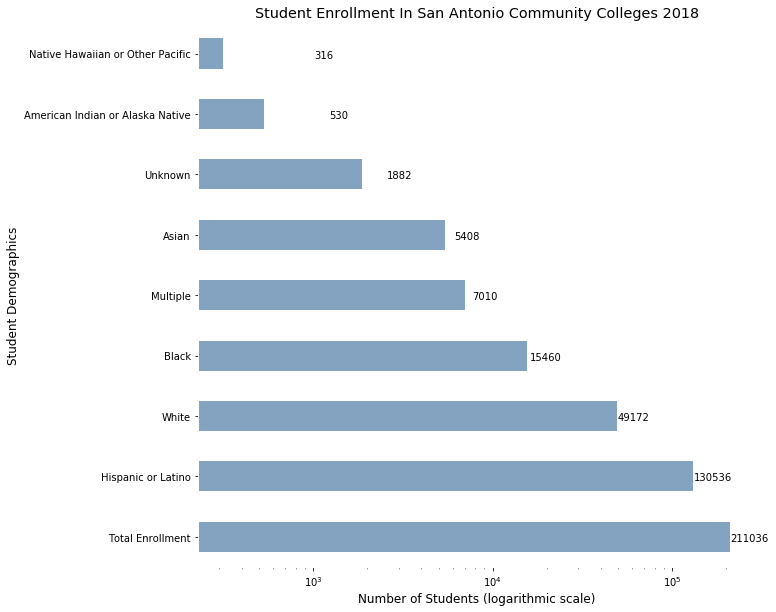

In [15]:
df_san_summary = get_demographic_summary(df_san)

blue_grey = (0.2, 0.4, 0.6, 0.6)

df_san_summary.plot(kind='barh', figsize=(10, 10), legend=False, color=blue_grey)
      
plt.grid(b=None)
plt.xlabel('Number of Students (logarithmic scale)')
plt.ylabel('Student Demographics')
plt.title('Student Enrollment In San Antonio Community Colleges 2018')
plt.xscale("log")
ax = plt.gca()

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+700, i.get_y()+.18, \
            str(round((i.get_width()), 2)), fontsize=10, color='black') 

ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_facecolor('w')

plt.show()

#### Phoenix Enrollment Summary

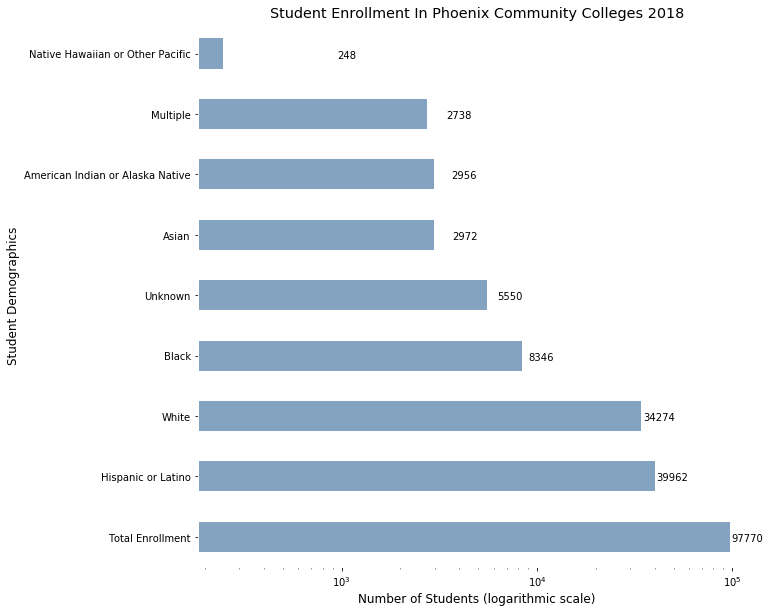

In [16]:
df_phx_summary = get_demographic_summary(df_phx)

blue_grey = (0.2, 0.4, 0.6, 0.6)

df_phx_summary.plot(kind='barh', figsize=(10, 10), legend=False, color=blue_grey)
      
plt.grid(b=None)
plt.xlabel('Number of Students (logarithmic scale)')
plt.ylabel('Student Demographics')
plt.title('Student Enrollment In Phoenix Community Colleges 2018')
plt.xscale("log")
ax = plt.gca()

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+700, i.get_y()+.18, \
            str(round((i.get_width()), 2)), fontsize=10, color='black') 

ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_facecolor('w')

plt.show()

#### Dallas Fort Worth Enrollment Summary

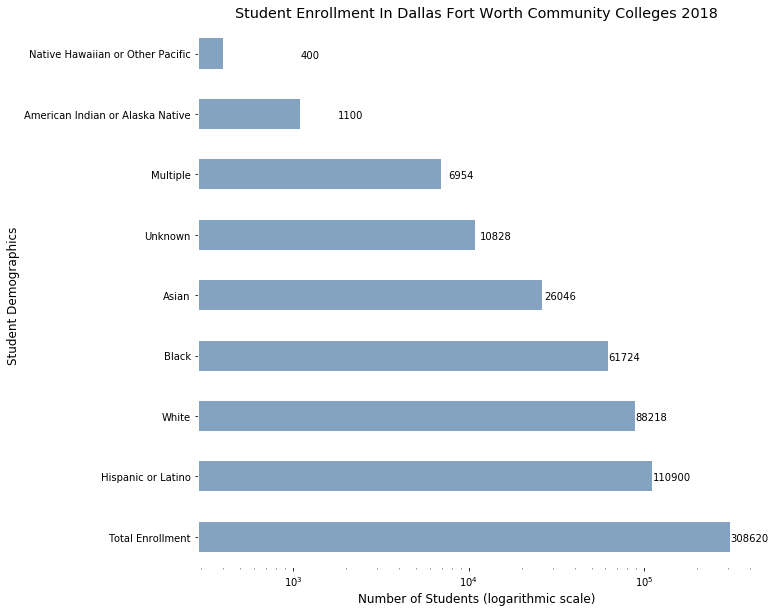

In [17]:
df_dfw_summary = get_demographic_summary(df_dfw)


blue_grey = (0.2, 0.4, 0.6, 0.6)

df_dfw_summary.plot(kind='barh', figsize=(10, 10), legend=False, color=blue_grey)
      
plt.grid(b=None)
plt.xlabel('Number of Students (logarithmic scale)')
plt.ylabel('Student Demographics')
plt.title('Student Enrollment In Dallas Fort Worth Community Colleges 2018')
plt.xscale("log")
ax = plt.gca()

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+700, i.get_y()+.18, \
            str(round((i.get_width()), 2)), fontsize=10, color='black') 

ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_facecolor('w')

plt.show()

### Call FourSquare API and Get Venues Near Each of the Community Colleges

Get the 50 closest venues to each school within a radius of 5000 meters.

In [18]:
# function that collects all the venues that are nearby a given latitude and longitude  

VERSION = '20180605'

def get_nearby_venues(names, latitudes, longitudes):
    venues_list = []
    LIMIT = 50
    radius = 5000
    url = 'https://api.foursquare.com/v2/venues/explore'

    for name, lat, lng in zip(names, latitudes, longitudes):
        
        params = dict(
            client_id=CLIENT_ID,
            client_secret=CLIENT_SECRET,
            ll=str(lat) + ',' + str(lng),
            v=VERSION,
            radius=radius,
            limit=LIMIT)

        results = requests.get(url, params=params)

        if results.status_code == 200:
            results = results.json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name,
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['College Name',
                             'Nearby Venue',
                             'Latitude',
                             'Longitude',
                             'Category']

    return nearby_venues

In [19]:
# Collect all the nearby venues for each community college in each city

san_venues = get_nearby_venues(names=df_san['Name'], 
                               latitudes=df_san['Latitude'], 
                               longitudes=df_san['Longitude'])
phx_venues = get_nearby_venues(names=df_phx['Name'], 
                               latitudes=df_phx['Latitude'], 
                               longitudes=df_phx['Longitude'])
dfw_venues = get_nearby_venues(names=df_dfw['Name'], 
                               latitudes=df_dfw['Latitude'],
                               longitudes=df_dfw['Longitude'])

print("Loaded all venue data")

Loaded all venue data


#### San Antonio Venues

In [20]:
san_venues.head()

,College Name,Nearby Venue,Latitude,Longitude,Category
0,St Philip's College,Mrs. Kitchen Soul Food Restaurant and Bakery,29.419323,-98.459417,Southern / Soul Food Restaurant
1,St Philip's College,AT&T Center,29.426889,-98.437409,Basketball Stadium
2,St Philip's College,Panchos Deli & Gringos Restaurant,29.427520,-98.470122,Café
3,St Philip's College,Dignowity Meats,29.425304,-98.471525,Sandwich Place
4,St Philip's College,Mark's Outing,29.419877,-98.470855,Burger Joint


#### Phoenix Venues

In [21]:
phx_venues.head()

,College Name,Nearby Venue,Latitude,Longitude,Category
0,Carrington College-Phoenix North,Bobby-Q's Restaurant,33.561050,-112.115841,BBQ Joint
1,Carrington College-Phoenix North,Akai Hana Sushi & Grill,33.554467,-112.110998,Sushi Restaurant
2,Carrington College-Phoenix North,Romanelli's,33.567134,-112.133233,Italian Restaurant
3,Carrington College-Phoenix North,LongHorn Steakhouse,33.578088,-112.118166,Steakhouse
4,Carrington College-Phoenix North,Barnes & Noble,33.580612,-112.121476,Bookstore


#### Dallas Fort Worth Venues

In [22]:
dfw_venues.head()

,College Name,Nearby Venue,Latitude,Longitude,Category
0,Dallas Institute of Funeral Service,El Palote Panaderia,32.755982,-96.683470,Vegetarian / Vegan Restaurant
1,Dallas Institute of Funeral Service,Cowboy Toyota,32.799703,-96.681533,Auto Dealership
2,Dallas Institute of Funeral Service,Circle Grill,32.800287,-96.683287,American Restaurant
3,Dallas Institute of Funeral Service,GameStop,32.761612,-96.684032,Video Game Store
4,Dallas Institute of Funeral Service,Shaved Ice Snow Cones,32.749018,-96.666204,Dessert Shop


### Perform Clustering Analysis

#### Convert Categorical Data Using One Hot Encoding

In [23]:
def get_one_hot_coding(df_venues):
    # one hot encoding
    df_one_hot = pd.get_dummies(df_venues[['Category']], prefix="", prefix_sep="")

    # add college name column back to dataframe
    df_one_hot['College Name'] = df_venues['College Name'] 

    # move college column to the first column
    fixed_columns = [df_one_hot.columns[-1]] + list(df_one_hot.columns[:-1])
    df_one_hot = df_one_hot[fixed_columns]
    
    return df_one_hot

san_onehot = get_one_hot_coding(san_venues)
dfw_onehot = get_one_hot_coding(dfw_venues)
phx_onehot = get_one_hot_coding(phx_venues)

print("One hot coding completed")

One hot coding completed


#### Group the Results By College Name and Calculate Means

In [24]:
san_grouped = san_onehot.groupby('College Name').mean().reset_index()
phx_grouped = phx_onehot.groupby('College Name').mean().reset_index()
dfw_grouped = dfw_onehot.groupby('College Name').mean().reset_index()

print("Grouping completed")

Grouping completed


#### San Antonio

In [25]:
san_grouped.head()

,College Name,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Beer Garden,Belgian Restaurant,Big Box Store,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Café,Cajun / Creole Restaurant,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food Court,Food Service,Football Stadium,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gift Shop,Gluten-free Restaurant,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kids Store,Latin American Restaurant,Lingerie Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Nail Salon,National Park,New American Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pub,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Southern / Soul Food Restaurant,Souvenir Shop,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Supplement Shop,Szechuan Restaurant,Taco Place,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Zoo Exhibit
0,Brightwood College-San Antonio-Ingram,0.04,0.00,0.02,0.02,0.00,0.0,0.00,0.0,0.00,0.02,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.00,0.04,0.00,0.00,0.00,0.00,0.08,0.0,0.0,0.00,0.02,0.00,0.02,0.00,0.00,0.0,0.02,0.00,0.04,0.0,0.00,0.0,0.00,0.04,0.02,0.00,0.00,0.00,0.0,0.0,0.02,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.02,0.00,0.0,0.06,0.00,0.0,0.02,0.02,0.00,0.00,0.04,0.02,0.0,0.02,0.02,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.00,0.0,0.00,0.00,0.02,0.0,0.02,0.00,0.0,0.0,0.00,0.00,0.02,0.02,0.0,0.02,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.02,0.04,0.00,0.02,0.02,0.00,0.02,0.00,0.00,0.00,0.00,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Brightwood College-San Antonio-San Pedro,0.04,0.02,0.02,0.02,0.00,0.0,0.00,0.0,0.02,0.04,0.0,0.0,0.00,0.0,0.0,0.04,0.0,0.00,0.02,0.02,0.00,0.02,0.02,0.00,0.0,0.0,0.00,0.00,0.02,0.00,0.02,0.00,0.0,0.00,0.00,0.00,0.0,0.02,0.0,0.00,0.02,0.00,0.00,0.00,0.00,0.0,0.0,0.02,0.00,0.04,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.0,0.0,0.0,0.02,0.02,0.04,0.00,0.0,0.00,0.02,0.0,0.00,0.02,0.00,0.02,0.08,0.00,0.0,0.00,0.00,0.02,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.02,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.06,0.0,0.04,0.00,0.02,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.04,0.00,0.00,0.02,0.02,0.00
2,Northwest Vista College,0.04,0.00,0.02,0.02,0.00,0.0,0.00,0.0,0.02,0.00,0.0,0.0,0.00,0.0,0.0,0.04,0.0,0.00,0.02,0.00,0.00,0.00,0.00,0.04,0.0,0.0,0.00,0.02,0.02,0.00,0.02,0.02,0.0,0.02,0.00,0.00,0.0,0.02,0.0,0.00,0.06,0.00,0.00,0.00,0.00,0.0,0.0,0.02,0.02,0.00,0.00,0.0,0.02,0.00,0.06,0.00,0.02,0.02,0.00,0.0,0.0,0.0,0.00,0.00,0.04,0.00,0.0,0.02,0.00,0.0,0.00,0.00,0.00,0.00,0.02,0.00,0.0,0.00,0.00,0.00,0.02,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.02,0.02,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.02,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.02,0.12,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.02
3,Palo Alto College,0.02,0.00,0.02,0.00,0.00,0.0,0.00,0.0,0.04,0.00,0.0,0.0,0.

#### Phoenix

In [26]:
phx_grouped.head()

,College Name,Accessories Store,Airport Lounge,Alternative Healer,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Baseball Field,Baseball Stadium,Beer Store,Big Box Store,Bookstore,Botanical Garden,Breakfast Spot,Brewery,Buffet,Burger Joint,Café,Caribbean Restaurant,Castle,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Dessert Shop,Discount Store,Dive Bar,Dog Run,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Historic Site,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Marijuana Dispensary,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mountain,Movie Theater,Museum,Music Venue,New American Restaurant,Office,Opera House,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pizza Place,Pool,Pub,Record Shop,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shopping Mall,Shopping Plaza,Soccer Field,Sporting Goods Shop,Sports Bar,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Zoo
0,Carrington College-Phoenix East,0.0,0.00,0.00,0.04,0.02,0.00,0.00,0.00,0.00,0.00,0.04,0.02,0.00,0.0,0.00,0.0,0.0,0.04,0.0,0.02,0.02,0.00,0.02,0.00,0.00,0.00,0.02,0.02,0.00,0.02,0.00,0.0,0.06,0.02,0.00,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.04,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.02,0.02,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.02,0.00,0.06,0.02,0.0,0.02,0.00,0.00,0.0,0.00,0.0,0.00,0.10,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.04,0.04,0.02,0.00,0.0,0.0,0.00,0.00,0.04,0.02,0.02,0.02,0.00,0.00,0.00,0.02,0.06,0.02,0.0,0.00,0.00,0.02,0.00,0.0,0.00
1,Carrington College-Phoenix North,0.0,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.06,0.02,0.02,0.00,0.00,0.0,0.00,0.0,0.0,0.04,0.0,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.00,0.0,0.06,0.02,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.04,0.0,0.00,0.02,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.02,0.04,0.02,0.00,0.00,0.00,0.0,0.00,0.00,0.06,0.00,0.04,0.00,0.0,0.02,0.00,0.02,0.0,0.00,0.0,0.00,0.08,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.02,0.00,0.02,0.0,0.02,0.0,0.02,0.00,0.04,0.02,0.00,0.0,0.0,0.02,0.00,0.06,0.02,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00
2,Fortis College-Phoenix,0.0,0.00,0.00,0.00,0.00,0.04,0.02,0.00,0.00,0.00,0.00,0.04,0.04,0.0,0.02,0.0,0.0,0.00,0.0,0.02,0.02,0.00,0.00,0.06,0.02,0.00,0.00,0.00,0.02,0.04,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.00,0.0,0.0,0.00,0.02,0.02,0.00,0.0,0.00,0.04,0.00,0.00,0.00,0.00,0.0,0.02,0.02,0.02,0.02,0.02,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.06,0.02,0.0,0.0,0.0,0.00,0.02,0.02,0.02,0.02,0.02,0.02,0.0,0.0,0.02,0.00,0.00,0.04,0.00,0.04,0.0,0.02,0.0,0.04,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.02,0.00,0.00,0.00,0.04,0.0,0.00,0.00,0.00,0.00,0.0,0.00
3,GateWay Community College,0.0,0.04,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.08,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.02,0.06,0.00,0.04,0.02,0.00,0.02,0.00,0.00,0.00,0.06,0.02,0.0,0.00,0.00,0.02,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.02,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.00,0.00,0.00,0.04,0.00,0.00,0.0,0.00,0.04,0.00,0.00,0.02,0.00,0.0,0.00,0.02,0.00,0.0,0.00,0.0,0.00,0.04,0.00,0.0

#### Dallas Fort Worth

In [27]:
dfw_grouped.head()

,College Name,Accessories Store,African Restaurant,Airport,American Restaurant,Art Museum,Auto Dealership,BBQ Joint,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Bookstore,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Café,Cajun / Creole Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Electronics Store,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food Truck,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Herbs & Spices Store,Historic Site,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Lake,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Motorsports Shop,Movie Theater,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Opera House,Optical Shop,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Pub,Record Shop,Recreation Center,Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Soccer Field,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Stables,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Brightwood College-Dallas,0.02,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.0,0.00,0.02,0.00,0.02,0.00,0.02,0.02,0.00,0.02,0.0,0.02,0.0,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.02,0.00,0.02,0.00,0.06,0.02,0.02,0.0,0.00,0.0,0.02,0.02,0.02,0.0,0.00,0.02,0.02,0.00,0.00,0.02,0.1,0.02,0.0,0.00,0.0,0.00,0.08,0.02,0.00,0.02,0.00,0.02,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.02,0.00,0.0,0.00,0.02,0.00,0.0,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.02,0.00,0.02,0.00,0.0,0.0,0.00,0.00,0.02,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.02,0.02,0.02,0.02,0.00,0.0,0.0,0.0,0.02,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00
1,Brightwood College-Fort Worth,0.00,0.0,0.0,0.04,0.00,0.00,0.0,0.02,0.00,0.06,0.00,0.04,0.00,0.00,0.02,0.00,0.12,0.04,0.0,0.00,0.00,0.00,0.00,0.04,0.02,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.02,0.02,0.02,0.02,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.02,0.00,0.00,0.0,0.0,0.0,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.06,0.02,0.00,0.00,0.02,0.00,0.0,0.00,0.0,0.04,0.0,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.0,0.0,0.0,0.02,0.02,0.00,0.0,0.00,0.02,0.0,0.00,0.00,0.02,0.0,0.02,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.04,0.00,0.00,0.00,0.02,0.04,0.00,0.00,0.00,0.0,0.0,0.0,0.02,0.00,0.00,0.00,0.04,0.00,0.0,0.0,0.02,0.0,0.00
2,Concorde Career College-Dallas,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.04,0.00,0.02,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.10,0.0,0.02,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.02,0.02,0.00,0.04,0.0,0.00,0.04,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.0,0.02,0.0,0.00,0.00,0.00,0.0,0.02,0.06,0.00,0.02,0.02,0.00,0.0,0.00,0.0,0.00,0.0,0.02,0.04,0.00,0.00,0.02,0.02,0.02,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.02,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.06,0.00,0.0,0.0,0.02,0.00,0.00,0.0,0.0,0.0,0.02,0.02,0.00,0.04,0.00,0.02,0

### Get the Top Venues and Sort Them

In each surrounding area of the community college display the top 5 venue categories.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
def get_top_venue_categories(df_grouped):
    num_top_venues = 5

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['College Name']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    venues_sorted = pd.DataFrame(columns=columns)
    venues_sorted['College Name'] = df_grouped['College Name']

    for ind in np.arange(df_grouped.shape[0]):
        venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

    return venues_sorted

In [30]:
san_sorted = get_top_venue_categories(san_grouped)
phx_sorted = get_top_venue_categories(phx_grouped)
dfw_sorted = get_top_venue_categories(dfw_grouped)

### Calculate the Best Cluster Sizes

For each city calculate the best cluster size using the sillhouette method and plot the results. The max score 
indicates the optimal cluster size to use.

In [31]:
# Function to calculate silhouette score to find optimum cluster size
def get_silhouette_score(df_grouped):
    sil = []
    
    df_grouped_clustering = df_grouped.drop('College Name', 1)
    
    index = df_grouped_clustering.index
    number_of_rows = len(index)
    
    K = range(2,number_of_rows)

    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in K:
        clusterer = KMeans(n_clusters = k)
        preds = clusterer.fit_predict(df_grouped_clustering)
        centers = clusterer.cluster_centers_
        score = silhouette_score(df_grouped_clustering, preds)
        sil.append(score)
        
    return (K, sil)

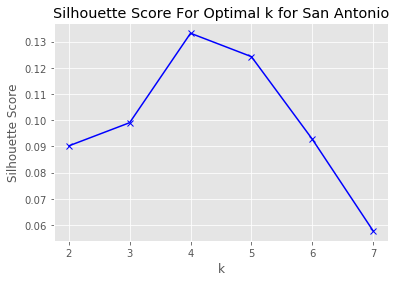

In [32]:
sil = get_silhouette_score(san_grouped)

plt.plot(sil[0], sil[1], 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k for San Antonio')
plt.show()

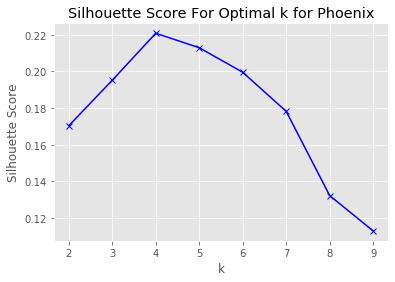

In [33]:
sil = get_silhouette_score(phx_grouped)

plt.plot(sil[0], sil[1], 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k for Phoenix')
plt.show()

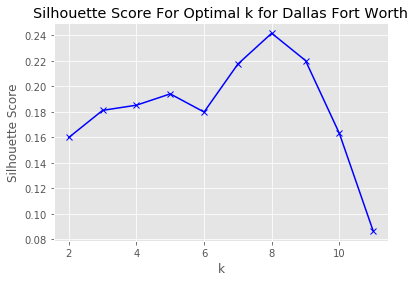

In [34]:
sil = get_silhouette_score(dfw_grouped)

plt.plot(sil[0], sil[1], 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k for Dallas Fort Worth')
plt.show()

### Find the Clusters for Each City

In [35]:
def get_clusters(df_grouped, clusters):
    # set number of clusters
    kclusters = clusters
    
    df_grouped_clustering = df_grouped.drop('College Name', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init="k-means++", n_init=12 ).fit(df_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    return kmeans

In [36]:
kmeans = get_clusters(san_grouped, 4)

# add clustering labels
san_sorted.insert(0, 'Cluster', kmeans.labels_)
san_sorted.sort_values(by=['Cluster'], ascending=True, inplace=True)

san_sorted

,Cluster,College Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Brightwood College-San Antonio-Ingram,Coffee Shop,Italian Restaurant,American Restaurant,Gym,Mexican Restaurant
6,0,The College of Health Care Professions-San Ant...,Coffee Shop,Chinese Restaurant,Mexican Restaurant,Bakery,Sandwich Place
1,1,Brightwood College-San Antonio-San Pedro,Mexican Restaurant,Seafood Restaurant,Hotel,Thai Restaurant,Bookstore
3,1,Palo Alto College,Mexican Restaurant,Fried Chicken Joint,Cosmetics Shop,Wings Joint,Fast Food Restaurant
7,1,The College of Health Care Professions-South S...,Mexican Restaurant,Burger Joint,BBQ Joint,Convenience Store,Seafood Restaurant
4,2,San Antonio College,Burger Joint,Lounge,Bar,Coffee Shop,Hotel
5,2,St Philip's College,Hotel,Mexican Restaurant,Beer Garden,Cocktail Bar,Sandwich Place
2,3,Northwest Vista College,Theme Park,Theme Park Ride / Attraction,Fast Food Restaurant,Grocery Store,Hotel


In [37]:
kmeans = get_clusters(phx_grouped, 2)

# add clustering labels
phx_sorted.insert(0, 'Cluster', kmeans.labels_)
phx_sorted.sort_values(by=['Cluster'], ascending=True, inplace=True)

phx_sorted

,Cluster,College Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,0,Fortis College-Phoenix,Café,Mexican Restaurant,Taco Place,Grocery Store,Pizza Place
3,0,GateWay Community College,Taco Place,Bakery,Brewery,Restaurant,Coffee Shop
7,0,Refrigeration School Inc,Brewery,Bakery,Taco Place,Hotel,Airport Lounge
0,1,Carrington College-Phoenix East,Mexican Restaurant,Convenience Store,Italian Restaurant,Trail,Steakhouse
1,1,Carrington College-Phoenix North,Mexican Restaurant,Ice Cream Shop,Asian Restaurant,Convenience Store,Steakhouse
4,1,Paradise Valley Community College,Coffee Shop,Convenience Store,Pizza Place,Mexican Restaurant,Italian Restaurant
5,1,Phoenix College,Pizza Place,Mexican Restaurant,Park,Hotel,Vegetarian / Vegan Restaurant
6,1,Pima Medical Institute-Phoenix,Pizza Place,Seafood Restaurant,Chinese Restaurant,Italian Restaurant,Fast Food Restaurant
8,1,South Mountain Community College,Mexican Restaurant,Gym / Fitness Center,Trail,BBQ Joint,Golf Course
9,1,Universal Technical Institute of Arizona Inc-M...,Coffee Shop,American Restaurant,Pizza Place,Fast Food Restaurant,Mexican Restaurant


In [38]:
kmeans = get_clusters(dfw_grouped, 7)

# add clustering labels
dfw_sorted.insert(0, 'Cluster', kmeans.labels_)
dfw_sorted.sort_values(by=['Cluster'], ascending=True, inplace=True)

dfw_sorted

,Cluster,College Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,0,KD Conservatory College of Film and Dramatic Arts,Mexican Restaurant,Brewery,Burger Joint,BBQ Joint,Sushi Restaurant
1,1,Brightwood College-Fort Worth,Brewery,Hotel,Bar,Beer Bar,Steakhouse
4,1,El Centro College,Hotel,Coffee Shop,American Restaurant,Steakhouse,Movie Theater
10,1,Tarrant County College District,Brewery,Hotel,Coffee Shop,Steakhouse,Bar
3,2,Dallas Institute of Funeral Service,Pharmacy,Chinese Restaurant,Mexican Restaurant,Discount Store,Video Game Store
7,2,Mountain View College,Mexican Restaurant,Discount Store,Wings Joint,Coffee Shop,Taco Place
2,3,Concorde Career College-Dallas,Burger Joint,Ice Cream Shop,Vietnamese Restaurant,Seafood Restaurant,Mexican Restaurant
9,3,Richland College,Burger Joint,Seafood Restaurant,Mexican Restaurant,Ice Cream Shop,Mediterranean Restaurant
0,4,Brightwood College-Dallas,Korean Restaurant,Mexican Restaurant,Grocery Store,Accessories Store,Fried Chicken Joint
6,4,MediaTech Institute-Dallas,Mexican Restaurant,Motorcycle Shop,Fast Food Restaurant,Recreation Center,Korean Restaurant


### Display the Location of the Colleges with Cluster Labels

#### San Antonio

In [39]:
df_merged = pd.merge(san_sorted,df_san[['Name','Longitude', 'Latitude']],left_on='College Name', right_on='Name', how='left')

df_merged.drop('Name', axis=1, inplace=True)

address = 'San Antonio, TX'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of San Antonio are {}, {}.'.format(latitude, longitude))


# create map
map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['College Name'], df_merged['Cluster']):
    label = '{} in Cluster {}'.format(name, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

The geograpical coordinates of San Antonio are 29.4246002, -98.4951405.


#### Phoenix

In [40]:
df_merged = pd.merge(phx_sorted,df_phx[['Name','Longitude', 'Latitude']],left_on='College Name', right_on='Name', how='left')

df_merged.drop('Name', axis=1, inplace=True)

address = 'Phoenix, AZ'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Phoenix are {}, {}.'.format(latitude, longitude))


# create map
map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['College Name'], df_merged['Cluster']):
    label = '{} in Cluster {}'.format(name, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

The geograpical coordinates of Phoenix are 33.4484367, -112.0741417.


#### Dallas Fort Worth

In [41]:
df_merged = pd.merge(dfw_sorted,df_dfw[['Name','Longitude', 'Latitude']],left_on='College Name', right_on='Name', how='left')

df_merged.drop('Name', axis=1, inplace=True)

address = 'Dallas, TX'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Dallas Fort Worth are {}, {}.'.format(latitude, longitude))


# create map
map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['College Name'], df_merged['Cluster']):
    label = '{} in Cluster {}'.format(name, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

The geograpical coordinates of Dallas Fort Worth are 32.7762719, -96.7968559.
